## Povprečne mesečne plače po občinah

### Projekt pri podatkovnem rudarjenju

Podatkovno rudarjenje, projekt, `27. 5. 2020`  
**`Domen Ramšak`**

### Opis problema

Izbran problem (oziroma zbirka podatkov) je Povprečne mesečne plače po občinah, Slovenija, letno.

Problem zajema povprečne bruto in neto plače po občinah v Sloveniji, z dodatnimi podatki kot so opravljene (oz. plačane) nadure, število oseb, ki so opravljale nadure na mesec, število oseb, ki so prejele zaostala izplačila itd.

Vse vrednosti so povprečne mesečne vrednosti, ki so razdeljena na leta (npr. povp. neto plača na mesec v letu 2015 itd.)

Ti podatki podajo več zanimivih vprašanj, kot npr.:
  * V katerij regijah Slovenije so plače višje/nižje?
  * Kako izgleda rast/upad plač skozi leta (posledice recesije?)?
  * Kje je opravljenih največ nadur, in kje so te najbolje plačane?
  * Kakšne so vrednosti, če upoštevano/primerjmo inflacijo?
  
Cilj je seveda analiza, pregled in vizualizacija teh podatkov, ter njihova razdelitev po regijah. Zanima nas tudi razporeditev plač po Sloveniji.

### Podatki

V podatkovni datoteki so podane sledeče vrednosti:
 * Povprečna mesečna bruto plača
 * Povprečna mesečna neto plača
 * Indeks povprečne mesečne bruto plače
 * Indeks povprečne mesečne neto plače
 * Povprečna plača za plačano naduro
 * Povprečna mesečna bruto plača za plačano uro
 * Povprečna mesečna neto plača za plačano uro
 * Indeks povprečne mesečne bruto plače za plačano uro
 * Indeks povprečne mesečne neto plače za plačano uro
 * Zaposlene osebe, ki so prejele zaostala izplačila
 * Zaposlene osebe z izplačanimi nadurami
 
Vrednosti so za leta od 2005 do 2019, in so povprečja celotnega leta za posamezne občine v Sloveniji (katerih je 211).

Pred čiščenjem je bilo v podatkih skupaj 700 praznih vrednosti (v podatkih označenih z "-").

Iz podatkov sva odstranila vnose za občine Ankaran in Mirna, saj so tem občinam manjkali podatki za vrsto let (tako je skupaj 209 občin). Odstranila sva tudi leto 2005 za indeks povprečne mesečne plače za plačano uro, saj je to leto bilo popolnoma prazno.

Za potrebe analize sva uporabljala samo neto vrednosti (namesto bruto), saj ponujajo boljšo predstavitev dejanskega denarnega prihodka za posamezno občino.


In [264]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import geopandas
import warnings
import re
import unidecode
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio

data = pd.read_excel('podatki/0772615.xlsx', index_col=0, header=1)  
print(data.where(data == "-").count().sum())

data = data.drop(["Ankaran", "Mirna"])
data = data.replace(r'-','0').astype(np.float64)

C:\Users\Domen\.conda\envs\pr_naloge\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\Domen\.conda\envs\pr_naloge\lib\site-packages\xlrd\xlsx.py:312: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\Domen\.conda\envs\pr_naloge\lib\site-packages\xlrd\xlsx.py:266: DeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


700


C:\Users\Domen\.conda\envs\pr_naloge\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [2]:
index = np.array([])
for i in data.index:
    if(re.search("/", i)):
#         print(i)
        i = re.sub("/.*", "", i)
#         print(i)
    index = np.append(i, index)
data.index = index

In [3]:
povpMesecnaPlacaNeto = data.iloc[:, 15:30]
indeksPovpMesecnaPlacaNeto = data.iloc[:, 45:60]
povpPlacaNadure = data.iloc[:, 60:75]
povpMesecnaPlacaNetoUra = data.iloc[:, 90:105]
indeksPovpMesecnaPlacaNetoUra = data.iloc[:, 120:135]
osebeZaostalaPlacila = data.iloc[:, 135:150]
osebeNadure = data.iloc[:, 150:165]

In [4]:
count = 0
for h in range(2005, 2020):
    povpMesecnaPlacaNeto = povpMesecnaPlacaNeto.rename(columns={povpMesecnaPlacaNeto.columns[count]: h})
    indeksPovpMesecnaPlacaNeto = indeksPovpMesecnaPlacaNeto.rename(columns={indeksPovpMesecnaPlacaNeto.columns[count]: h})
    povpPlacaNadure = povpPlacaNadure.rename(columns={povpPlacaNadure.columns[count]: h})
    povpMesecnaPlacaNetoUra = povpMesecnaPlacaNetoUra.rename(columns={povpMesecnaPlacaNetoUra.columns[count]: h})
    indeksPovpMesecnaPlacaNetoUra = indeksPovpMesecnaPlacaNetoUra.rename(columns={indeksPovpMesecnaPlacaNetoUra.columns[count]: h})
    osebeZaostalaPlacila = osebeZaostalaPlacila.rename(columns={osebeZaostalaPlacila.columns[count]: h})
    osebeNadure = osebeNadure.rename(columns={osebeNadure.columns[count]: h})
    count+=1
    
indeksPovpMesecnaPlacaNetoUra = indeksPovpMesecnaPlacaNetoUra.drop(columns=2005)

### Predstavitev podatkov

Pri podatkih lahko opazimo vrsto "SLOVENIJA"; to je povprečje za vse vrednosti, za celotno Slovenijo. S tem lahko zelo lahko najdemo povp. vrednosti za vsak razred. Izrisal sem jih samo za to povprečje, saj bi bilo izris za vseh 211 občin nekoliko preveč.

Text(0.5, 1.0, 'Povp. oseb z nadurami skozi čas')

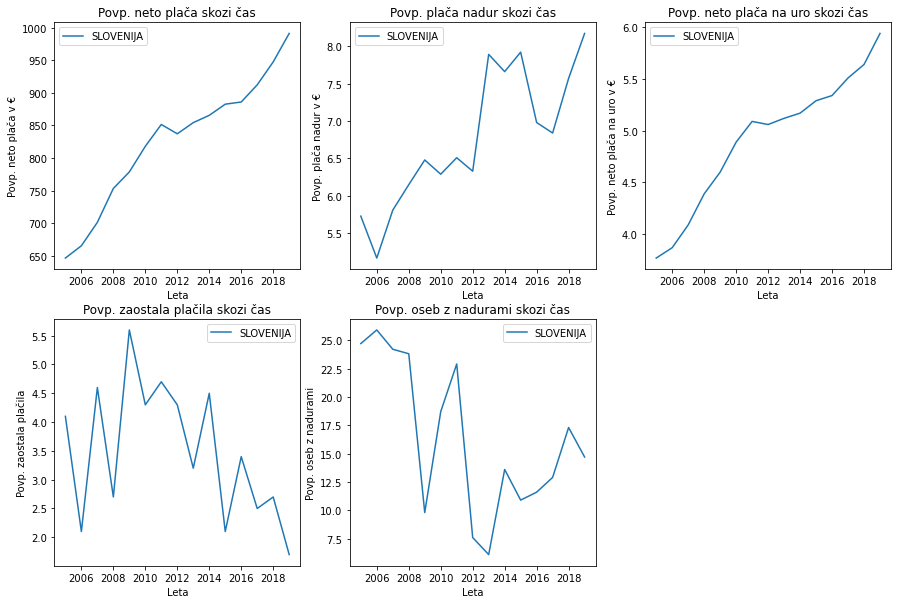

In [5]:
# Funkcija za izdelavo subplotov z pandas uporablja depreceted funkcijo in meče opozorila. Ne morem na to vplivati zato sem za 
# ta cell opozorila izklopil.
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(2, 3)
fig.delaxes(axs[1][2])
fig.set_figheight(10)
fig.set_figwidth(15)

povpMesecnaPlacaNeto.loc[["SLOVENIJA"],:].transpose().plot(ax=axs[0,0])
axs[0, 0].set(xlabel="Leta", ylabel="Povp. neto plača v €")
axs[0, 0].legend()
axs[0, 0].set_title("Povp. neto plača skozi čas")

povpPlacaNadure.loc[["SLOVENIJA"],:].transpose().plot(ax=axs[0,1])
axs[0, 1].set(xlabel="Leta", ylabel="Povp. plača nadur v €")
axs[0, 1].legend()
axs[0, 1].set_title("Povp. plača nadur skozi čas")

povpMesecnaPlacaNetoUra.loc[["SLOVENIJA"],:].transpose().plot(ax=axs[0,2])
axs[0, 2].set(xlabel="Leta", ylabel="Povp. neto plača na uro v €")
axs[0, 2].legend()
axs[0, 2].set_title("Povp. neto plača na uro skozi čas")

osebeZaostalaPlacila.loc[["SLOVENIJA"],:].transpose().plot(ax=axs[1,0])
axs[1, 0].set(xlabel="Leta", ylabel="Povp. zaostala plačila")
axs[1, 0].legend()
axs[1, 0].set_title("Povp. zaostala plačila skozi čas")

osebeNadure.loc[["SLOVENIJA"],:].transpose().plot(ax=axs[1, 1])
axs[1, 1].set(xlabel="Leta", ylabel="Povp. oseb z nadurami")
axs[1, 1].legend()
axs[1, 1].set_title("Povp. oseb z nadurami skozi čas")

In [6]:
# Funkcija za izdelavo subplotov z pandas uporablja depreceted funkcijo in meče opozorila. Ne morem na to vplivati zato sem za 
# ta cell opozorila izklopil. Tule se nazaj vklopijo
warnings.filterwarnings('always')

Iz podanih grafo se lepo vidi da so skoraj vse metrike upadle/stagnirale v letih od prib. 2008 do prib. 2015, najverjetneje kot posledica finančne krize 2007-2008. Link o krizi: https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%9308

#### Povprečna neto plača


Pri vseh letih je največja plača v občini **Cerklje na Gorenjskem**. 

In [7]:
df = pd.DataFrame(columns=range(2005, 2020))
df.insert(0, "", "")
df = df.set_index("")

for l in range(2005, 2020):
    cache = povpMesecnaPlacaNeto.sort_values(l, ascending=0)
    
    for i in range(0, 3):
        if(cache.iloc[:, 0].index[i] not in df.index):
            df = df.append(cache.iloc[i, :])
    
    
for l in range(2005, 2020):
    cache = povpMesecnaPlacaNeto.sort_values(l, ascending=0)
    
    for i in range(0, len(df.index)):
        if(df.iloc[i, l-2005] not in cache[l].head(3).values):
            df.at[df.iloc[:, 0].index[i], l] = 0

def h_max(s):
    is_max = s == s.max()
    return ['background-color: #FF6200' if v else '' for v in is_max]

def h_max2(s):
    is_max = s == s.nlargest(3).to_numpy()[1]
    return ['background-color: #FD9346' if v else '' for v in is_max]

def h_max3(s):
    is_max = s == s.nlargest(3).to_numpy()[2]
    return ['background-color: #FDB777' if v else '' for v in is_max]

df = df.round(2)
df.style.apply(h_max).apply(h_max2).apply(h_max3).format('{0:,.2f}')



,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
,,,,,,,,,,,,,,,
Veržej,994.07,"1,028.63","1,065.88","1,179.98","1,147.61","1,173.70","1,182.71","1,187.71","1,378.65","1,393.08","1,431.88","1,404.53","1,438.70","1,445.17","1,433.90"
Ruše,857.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Preddvor,848.09,889.75,963.60,"1,042.35","1,081.27","1,106.95","1,125.64","1,124.97","1,125.61","1,130.74","1,140.33","1,159.83","1,197.56","1,231.47","1,281.66"
Hrpelje - Kozina,0.00,886.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Šmartno pri Litiji,0.00,0.00,955.73,"1,066.81",0.00,"1,066.37","1,119.90","1,120.90",0.00,0.00,0.00,0.00,0.00,0.00,0.00
Hajdina,0.00,0.00,0.00,0.00,"1,052.42",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Mengeš,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"1,116.34","1,145.87","1,138.56","1,149.06","1,173.36","1,217.78","1,286.19"


In [8]:
povpMesecnaPlacaNeto.loc[["SLOVENIJA", "Cerklje na Gorenjskem"],:]

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
SLOVENIJA,646.23,665.11,701.15,753.22,778.59,818.01,851.58,837.25,854.39,865.64,882.77,886.12,912.50,947.74,991.52
Cerklje na Gorenjskem,741.05,771.12,810.35,825.41,861.23,876.38,899.41,921.15,923.85,937.34,900.57,921.78,932.21,952.13,1009.41


Text(0, 0.5, 'Povp. neto plača v €')

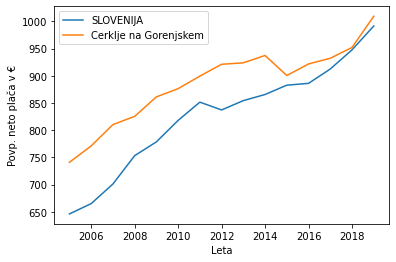

In [9]:
ax = povpMesecnaPlacaNeto.loc[["SLOVENIJA", "Cerklje na Gorenjskem"],:].transpose().plot()
ax.set_xlabel("Leta")
ax.set_ylabel("Povp. neto plača v €")

**Cerklje na Gorenjskem** ima večje povp. kot naslednjih 9 občin z največjim povp. v letu 2019, kar je definitivno presenetljivo:

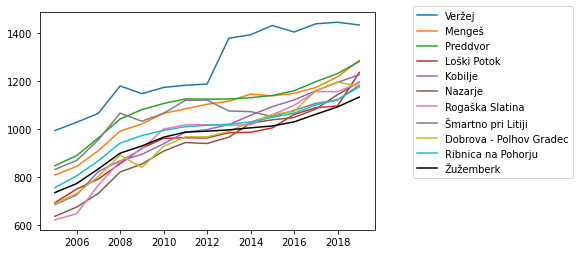

In [10]:
povpMesecnaPlacaNeto.sort_values(2019, ascending=0).head(10).transpose().plot()
ax = povpMesecnaPlacaNeto.iloc[0, :].plot(color="black")
ax.legend(bbox_to_anchor=(1.1, 1.05))

#### Povprečna plača za nadure

Največja plača nadur je veliko bolj razpršena kot povp. plača. Spodnja tabela prikazuje največje tri vrednosti za vsako leto. Gradient je sledeč: temno - večja vrednost, svetlo - manjša vrednost.

In [11]:
df = pd.DataFrame(columns=range(2005, 2020))
df.insert(0, "", "")
df = df.set_index("")

for l in range(2005, 2020):
    cache = povpPlacaNadure.sort_values(l, ascending=0)
    
    for i in range(0, 3):
        if(cache.iloc[:, 0].index[i] not in df.index):
            df = df.append(cache.iloc[i, :])
    
    
for l in range(2005, 2020):
    cache = povpPlacaNadure.sort_values(l, ascending=0)
    
    for i in range(0, len(df.index)):
        if(df.iloc[i, l-2005] not in cache[l].head(3).values):
            df.at[df.iloc[:, 0].index[i], l] = 0

def h_max(s):
    is_max = s == s.max()
    return ['background-color: #FF6200' if v else '' for v in is_max]

def h_max2(s):
    is_max = s == s.nlargest(3).to_numpy()[1]
    return ['background-color: #FD9346' if v else '' for v in is_max]

def h_max3(s):
    is_max = s == s.nlargest(3).to_numpy()[2]
    return ['background-color: #FDB777' if v else '' for v in is_max]

df = df.round(2)
df.style.apply(h_max).apply(h_max2).apply(h_max3).format('{0:,.2f}')


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
,,,,,,,,,,,,,,,
Cerkno,21.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Horjul,14.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dolenjske Toplice,11.27,13.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Veržej,0.00,12.14,11.91,16.96,18.68,19.11,0.00,19.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Grad,0.00,11.92,0.00,13.41,22.00,0.00,19.19,20.41,20.07,0.00,19.95,20.09,18.95,19.56,20.89
Brda,0.00,0.00,12.37,0.00,19.64,20.11,0.00,0.00,16.28,0.00,0.00,0.00,0.00,0.00,0.00
Solčava,0.00,0.00,11.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sodražica,0.00,0.00,0.00,13.81,0.00,0.00,17.43,17.13,16.80,0.00,0.00,17.70,17.18,17.99,0.00
Renče - Vogrsko,0.00,0.00,0.00,0.00,0.00,61.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Največje plače za nadure po letih.

In [12]:
df = pd.DataFrame(columns=range(2005, 2020))


for l in range(2005, 2020):
    cache = povpPlacaNadure.sort_values(l, ascending=0)
    df.at[0, l] = cache.iloc[:, 0].index[0]
    df.at[1, l] = cache.iloc[0, l-2005]
    
df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Cerkno,Dolenjske Toplice,Brda,Veržej,Grad,Renče - Vogrsko,Grad,Grad,Grad,Juršinci,Velenje,Grad,Grad,Beltinci,Bloke
1,21.07,13.47,12.37,16.96,22,61.93,19.19,20.41,20.07,25.15,25.47,20.09,18.95,20.08,22.04


Primerjava vseh teh občin čez leta:

<Figure size 432x288 with 0 Axes>

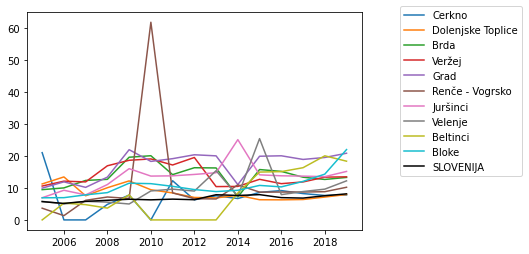

In [13]:
af = pd.DataFrame(columns=range(2005, 2020))
af.insert(0, "", "")
af = af.set_index("")

for v in df.iloc[0,:].values:
    if(v not in af.index):
        af = af.append(povpPlacaNadure.loc[v, :])
        
# af = af.append(povpPlacaNadure.loc["SLOVENIJA", :])
plt.figure()

af.transpose().plot()
ax = povpPlacaNadure.loc["SLOVENIJA", :].transpose().plot(color="black")
ax.legend(bbox_to_anchor=(1.1, 1.05))

Razkrije da je plača nadur v Kostel-ju leta 2010 osamelec. V primerjavi s številom oseb, katerim so te nadure bile izplačane:

<Figure size 432x288 with 0 Axes>

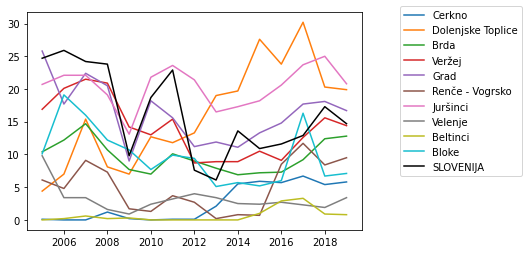

In [14]:
af = pd.DataFrame(columns=range(2005, 2020))
af.insert(0, "", "")
af = af.set_index("")

for v in df.iloc[0,:].values:
    if(v not in af.index):
        af = af.append(osebeNadure.loc[v, :])
        
# af = af.append(povpPlacaNadure.loc["SLOVENIJA", :])
plt.figure()

af.transpose().plot()
ax = osebeNadure.loc["SLOVENIJA", :].transpose().plot(color="black")
ax.legend(bbox_to_anchor=(1.1, 1.05))

Pokaže, da število oseb ni abnormalno nizko, kot sva pričakovala, ampak je celo konsistentno z povp. celotne Slovenije.

#### Zaposlene osebe, ki so prejele zaostala izplačila

Največ prejetih zaostalih plač se pojavi v Medvodah, sploh v letih od 2012 do 2018.

In [15]:
df = pd.DataFrame(columns=range(2005, 2020))
df.insert(0, "", "")
df = df.set_index("")

for l in range(2005, 2020):
    cache = osebeZaostalaPlacila.sort_values(l, ascending=0)
    
    for i in range(0, 3):
        if(cache.iloc[:, 0].index[i] not in df.index):
            df = df.append(cache.iloc[i, :])
    
    
for l in range(2005, 2020):
    cache = osebeZaostalaPlacila.sort_values(l, ascending=0)
    
    for i in range(0, len(df.index)):
        if(df.iloc[i, l-2005] not in cache[l].head(3).values):
            df.at[df.iloc[:, 0].index[i], l] = 0

def h_max(s):
    is_max = s == s.max()
    return ['background-color: #FF6200' if v else '' for v in is_max]

def h_max2(s):
    is_max = s == s.nlargest(3).to_numpy()[1]
    return ['background-color: #FD9346' if v else '' for v in is_max]

def h_max3(s):
    is_max = s == s.nlargest(3).to_numpy()[2]
    return ['background-color: #FDB777' if v else '' for v in is_max]

df = df.round(2)
df.style.apply(h_max).apply(h_max2).apply(h_max3).format('{0:,.2f}')

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
,,,,,,,,,,,,,,,
Polzela,26.40,0.00,0.00,0.00,0.00,32.90,0.00,0.00,0.00,0.00,0.00,35.20,0.00,0.00,0.00
Cerkvenjak,23.30,28.30,32.70,34.20,24.90,37.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Cerkno,21.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Pesnica,0.00,28.90,0.00,0.00,0.00,32.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Velika Polana,0.00,27.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sveti Jurij ob Ščavnici,0.00,0.00,27.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Bloke,0.00,0.00,25.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Brezovica,0.00,0.00,0.00,20.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Veržej,0.00,0.00,0.00,20.60,0.00,0.00,0.00,25.70,32.40,29.60,26.90,0.00,0.00,0.00,0.00


In [16]:
df = pd.DataFrame(columns=range(2005, 2020))


for l in range(2005, 2020):
    cache = osebeZaostalaPlacila.sort_values(l, ascending=0)
    df.at[0, l] = cache.iloc[:, 0].index[0]
    df.at[1, l] = cache.iloc[0, l-2005]
    
df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Polzela,Pesnica,Cerkvenjak,Cerkvenjak,Železniki,Cerkvenjak,Rogašovci,Medvode,Medvode,Medvode,Medvode,Medvode,Medvode,Hodoš,Hodoš
1,26.4,28.9,32.7,34.2,27.6,37.5,31.6,78.1,76.2,77.2,76.9,80.2,50,33.9,34.7


<Figure size 432x288 with 0 Axes>

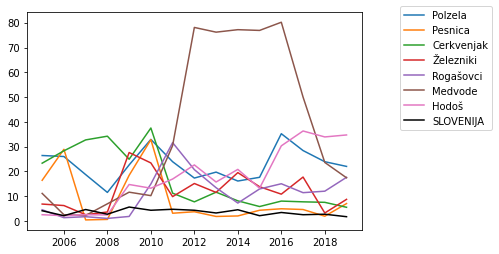

In [17]:
af = pd.DataFrame(columns=range(2005, 2020))
af.insert(0, "", "")
af = af.set_index("")

for v in df.iloc[0,:].values:
    if(v not in af.index):
        af = af.append(osebeZaostalaPlacila.loc[v, :])
        
# af = af.append(povpPlacaNadure.loc["SLOVENIJA", :])
plt.figure()

af.transpose().plot()
ax = osebeZaostalaPlacila.loc["SLOVENIJA", :].transpose().plot(color="black")
ax.legend(bbox_to_anchor=(1.1, 1.05))

### Delitev podatkov po regijah

Za prikaz podatkov na zemljevidu slovenije sem pridobil shapefile iz https://gadm.org/, ter z pomočjo knjižnice Geopandas zemljevide izrisal.

Za prikaz sem mogel podatke nekoliko prirediti, oz. predprocesirati; imena občin sem mogel spremeniti v primerno obliko (zaradi nekosistentnosti šumnikov in začetnic v bazi za zemljevid sem vse šumnike pretvoril), ter vse vrednosti razdeliti po statističnih regijah.

Vse vrednosti (neto plače, nadure, itd.) sem nato tudi normaliziral, da se graf lepo prikaže.

In [179]:
# Branje zemljevidov, popravljanje regij

si_regions = geopandas.read_file("shapefiles/gadm36_SVN_1.shp", encoding='utf-8')
si_counties = geopandas.read_file("shapefiles/gadm36_SVN_2.shp", encoding='utf-8')
si_regions = si_regions.drop(["NL_NAME_1", "CC_1", "TYPE_1", "ENGTYPE_1", "HASC_1", "GID_0", "NAME_0", "GID_1"], axis=1)
si_counties = si_counties.drop(["GID_0", "NAME_0", "GID_1", "NL_NAME_1", "GID_2", "NL_NAME_2", "VARNAME_2", "TYPE_2","ENGTYPE_2", "CC_2", "HASC_2"], axis=1)

si_regions.loc[si_regions["NAME_1"] == "Notranjsko-kraška", "NAME_1"] = "Primorsko-notranjska"
si_regions.loc[si_regions["NAME_1"] == "Spodnjeposavska", "NAME_1"] = "Posavska"

si_counties.loc[si_counties["NAME_1"] == "Notranjsko-kraška", "NAME_1"] = "Primorsko-notranjska"
si_counties.loc[si_counties["NAME_1"] == "Spodnjeposavska", "NAME_1"] = "Posavska"
# si_county.NAME_1.unique()

In [180]:
# Dict vseh regij in njihovih občin

regions = dict()

for region in si_counties.NAME_1.unique():
    regions[region] = si_counties[si_counties["NAME_1"] == region].NAME_2.values
        
# regions   

In [181]:
# Razdeljevanje v posebna arraya

regions_column = np.array([])
counties_column = np.array([])

for region in regions.keys():
    cache = np.array([region])   
    cache = np.repeat(cache, len(regions[region]))
    regions_column = np.append(regions_column, cache)
    counties_column = np.append(counties_column, regions[region])

index = np.array([])
for c in counties_column:
    index = np.append(index, unidecode.unidecode(c))

counties_column = index
    
regions_index = pd.MultiIndex.from_arrays([regions_column, counties_column], names=("region", "county"))
regions_values = pd.DataFrame(columns=range(2005, 2020), index=regions_index)

In [182]:
# Popravljanje šumnikov in začetnic

regions_povpMesecnaPlacaNeto = regions_values.copy()
regions_povpPlacaNadure = regions_values.copy()
regions_osebeNadure = regions_values.copy()

def fix_index(df):
    index = np.array([])
    for i in df.index:
        index = np.append(index, unidecode.unidecode(i))

    df.index = index

fix_index(povpMesecnaPlacaNeto)
fix_index(povpPlacaNadure)
fix_index(osebeNadure)

c1 = ""

for r in regions:
    for c in regions[r]:
        c = unidecode.unidecode(c)
        c1 = c
        c1 = re.sub("-", " - ", c)
        c1 = re.sub("Vas", "vas", c1)
        c1 = re.sub("Mesto", "mesto", c1)
        c1 = re.sub("Dolina", "dolina", c1)
        c1 = re.sub("Polju", "polju", c1)
        c1 = re.sub("Sveti Andraz v Slovenskih Goricah", "Sveti Andraz v Slov. goricah", c1)
        c1 = re.sub("Sentjur pri Celju", "Sentjur", c1)
        c1 = re.sub("Sveti Jurij", "Sveti Jurij ob Scavnici", c1)
            
        if(c1 in povpMesecnaPlacaNeto.index):
            regions_povpMesecnaPlacaNeto.loc[r, c] = povpMesecnaPlacaNeto.loc[c1]
            regions_povpPlacaNadure.loc[r, c] = povpPlacaNadure.loc[c1]
            regions_osebeNadure.loc[r, c] = osebeNadure.loc[c1]


In [183]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(regions_povpMesecnaPlacaNeto)

# # regions_values["Gorenjska"]["Bled"]

In [184]:
# Normalizacija s pomočjo knjižnice sklearn

def normalize_df(df):
    index = df.index
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled, columns=df.columns, index=index)
    return df

regions_povpMesecnaPlacaNeto_normal = normalize_df(regions_povpMesecnaPlacaNeto)
regions_povpPlacaNadure_normal = normalize_df(regions_povpPlacaNadure)
regions_osebeNadure_normal = normalize_df(regions_osebeNadure)

# regions_povpMesecnaPlacaNeto_normal
# regions_povpPlacaNadure_normal
# regions_osebeNadure_normal

In [274]:

def plot_gif(df, title):
    filenames = []
    
    for y in range(2005, 2020):
        fig, ax = plt.subplots(1, 1)
        fig.figsize=(20, 20)
        divider = make_axes_locatable(ax)

        cax = divider.append_axes("right", size="5%", pad=0.1)
        ax = si_regions.plot(edgecolor='black', figsize=(20, 20), column=y, legend=True, cax=cax, ax=ax, cmap="Blues")
        ax.figure.set_size_inches(15, 15)
        ax.set_aspect(1.5)
        ax.set_title("Razporeditev plač v letu 2005")
#         fig.axis('off')
        filenames.append("slike/zemljevid/" + title + str(y) + ".png")
        fig.savefig("slike/zemljevid/" + title + str(y), dpi=300)
        plt.close()
    
    images = []
    
    for filename in filenames:
        images.append(imageio.imread(filename))

    imageio.mimsave("slike/zemljevid/movie.gif", images)

In [187]:
# Prikaz vrednosti za občine

df = regions_povpMesecnaPlacaNeto_normal.groupby(level=0).mean()
df = normalize_df(df)
df.reset_index(inplace=True) 
df= df.drop(["region"], axis=1)

si_regions = si_regions.join(df)


In [275]:
plot_gif(si_regions, "obcine")

In [199]:
# # To se naj zažene samo enkrat
# regions_povpMesecnaPlacaNeto_normal.reset_index(inplace=True)  
# regions_povpMesecnaPlacaNeto_normal = regions_povpMesecnaPlacaNeto_normal.drop(["level_0", "index"], axis=1)
si_counties = si_counties.join(regions_povpMesecnaPlacaNeto_normal)

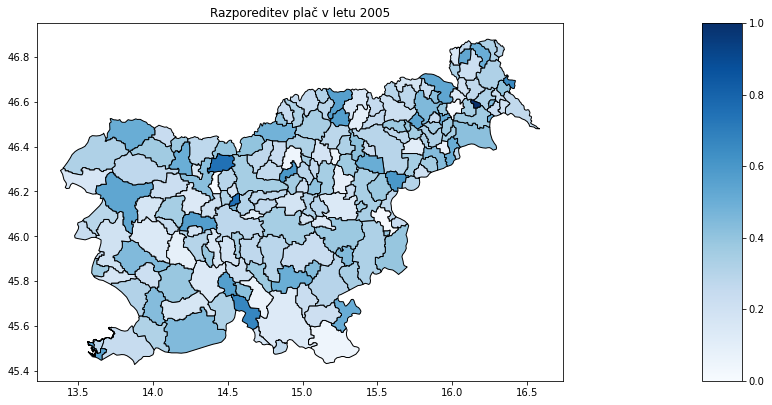

In [249]:
# Prikaz vrednosti za občine

fig, ax = plt.subplots(1, 1)
fig.figsize=(20, 20)
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)
ax = si_counties.plot(edgecolor='black', figsize=(20, 20), column=2019, legend=True, cax=cax, ax=ax, cmap="Blues")
ax.figure.set_size_inches(15, 15)
ax.set_aspect(1.5)
ax.set_title("Razporeditev plač v letu 2005")

# plt.show()

ax.collections

In [142]:
si_counties

,NAME_1,NAME_2,geometry,region,county,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Gorenjska,Bled,"POLYGON ((14.13989 46.37403, 14.13987 46.37048...",Gorenjska,Bled,0.341767,0.355894,0.427487,0.376401,0.347996,0.365139,0.418364,0.371134,0.312796,0.335338,0.336503,0.321283,0.332213,0.381278,0.365772
1,Gorenjska,Bohinj,"POLYGON ((14.10883 46.30289, 14.11906 46.30290...",Gorenjska,Bohinj,0.350097,0.335291,0.390800,0.364739,0.420217,0.383306,0.433511,0.281842,0.250296,0.246736,0.230747,0.218772,0.238721,0.276530,0.272599
2,Gorenjska,Cerklje na Gorenjskem,"POLYGON ((14.49683 46.20374, 14.49172 46.20374...",Gorenjska,Cerklje na Gorenjskem,0.506428,0.500892,0.521210,0.406736,0.484993,0.412887,0.465633,0.441139,0.327537,0.339555,0.269988,0.264896,0.243085,0.265883,0.293858
3,Gorenjska,Gorenja Vas-Poljane,"POLYGON ((14.21508 46.09678, 14.21507 46.09323...",Gorenjska,Gorenja Vas-Poljane,0.355793,0.395763,0.431872,0.448800,0.523261,0.285164,0.399257,0.434052,0.335921,0.358742,0.363927,0.341201,0.337712,0.320290,0.348438
4,Gorenjska,Jesenice,"POLYGON ((14.15406 46.44313, 14.14534 46.43804...",Gorenjska,Jesenice,0.293038,0.262976,0.313303,0.301610,0.336972,0.337493,0.349876,0.267501,0.229462,0.246939,0.241643,0.230345,0.229201,0.266137,0.238530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,Posavska,Krško,"POLYGON ((15.44916 45.78839, 15.44799 45.78785...",Posavska,Krsko,0.184031,0.192154,0.231572,0.208881,0.242559,0.290634,0.365267,0.302325,0.256314,0.282806,0.285569,0.278372,0.302832,0.337205,0.326563
188,Posavska,Sevnica,"POLYGON ((15.22126 45.92362, 15.21615 45.92362...",Posavska,Sevnica,0.468115,0.533919,0.708675,0.596727,0.697664,0.605182,0.642485,0.611254,0.338789,0.366408,0.351726,0.329278,0.361279,0.398282,0.381841
189,Zasavska,Hrastnik,"POLYGON ((15.09435 46.09060, 15.08418 46.10125...",Zasavska,Hrastnik,0.356749,0.330697,0.453776,0.438795,0.519251,0.443020,0.443470,0.421955,0.355601,0.261459,0.211772,0.183353,0.183173,0.256920,0.286040
190,Zasavska,Trbovlje,"POLYGON ((15.09435 46.09060, 15.09433 46.08704...",Zasavska,Trbovlje,0.505004,0.518820,0.567322,0.525583,0.566619,0.530381,0.622831,0.497683,0.313402,0.302398,0.313131,0.297163,0.329687,0.339766,0.316000
